<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

<left><img width=25% src="img/cu_logo.svg"></left>

# Lecture 02, hands-on: Building a classifier
*(CPBS 7602: Intro to Big Data in the Biomedical Sciences)*

By __Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Goals
* Identifying the components of a supervised learning problem.
* Basic understanding of tree-based algorithms.
* Basic overview of overfitting.

# Review: Regression vs. Classification

Consider a training dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

We distinguish between supervised learning problems depending on the targets $y^{(i)}$:

1. __Regression__: The target space is continuous: $\mathcal{Y} \subseteq \mathbb{R}$.
2. __Classification__: The target space is discrete: $\mathcal{Y} = \{y_1, y_2, \ldots y_K\}$. <br>
   <span style='color: gray'>Each of the $K$ discrete values corresponds to a *class* that we want to predict</span>

## Binary Classification

An important special case of classification is when the number of classes $K=2$.

In this case, we have an instance of a *binary classification* problem.

# The dataset

## An Example: Classifying Iris Flowers

Our running example for classification problems will be the __iris flower dataset__.

This is a classical dataset originally published by [R. A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1936.
<!-- Nowadays, it's often used for demonstrating machine learning algorithms. -->

<center><img width=70% src="img/iris.png"/> <br>
<small style='color: gray;'>Image source: <a href="https://www.datacamp.com/tutorial/machine-learning-in-r">Machine Learning in R for Beginners</a></small></center>

Let's import the dataset from `sklearn`.

In [1]:
import warnings

warnings.filterwarnings("ignore")
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)

In [2]:
iris_X, iris_y = iris.data, iris.target

## Exercise 1: Analyze the dataset

Look at the variables with the Iris flowers data above and answer the **questions** below.

*Tip:* running `print(iris.DESCR)` will give you a description of the dataset.

In [3]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

### Question 1

What's is the value of $n$ for this dataset? What is $n$?

_Answer_: 150 instances (or samples)

### Question 2

What's the value of $d$? What is $d$?

_Answer_: d represents the number of predictive features of Y. There are 4 numeric predictive variables. 

### Question 3

1. What variable has the inputs? What variable has the targets?
1. For $i=3$, answer:
   1. what does $x^{(i)}$ look like?
   2. and $y^{(i)}$?

In [20]:
print(iris.data[:3])
print(iris.target[:3])


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
0    0
1    0
2    0
Name: target, dtype: int64


_Answer_: 
1. Inputs have four variables = sepal length, sepal width, petal length, petal width. Targets are in class variable. 
2. x(i) looks like the above table for the four predictive columns (from `iris.data`). y(i) looks to all be 0 and is a variable that contains three values (0-2). 

### Question 4

Given the type of the targets, what kind of supervised learning approach should we use?
1. Is this a binary classificiation problem?

_Answer_: This is not a binary classification problem because there are more than two classes (there are three classes of flowers). We could use a multi-class classification ML approach. 

# The learning algorithm

## Decision Trees

### The UCI Diabetes Dataset

To explain what is a decision tree, we are going to use the UCI diabetes dataset that we have been working with earlier.

Let's start by loading this dataset.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 4]
from sklearn import datasets

# Load the diabetes dataset
diabetes = datasets.load_diabetes(as_frame=True, scaled=False)
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

We can also look at the data directly.

In [22]:
# Load the diabetes dataset
diabetes_X, diabetes_y = diabetes.data, diabetes.target

# create a binary risk feature
diabetes_y_risk = diabetes_y.copy()
diabetes_y_risk[:] = 0
diabetes_y_risk[diabetes_y > 150] = 1

# Print part of the dataset
diabetes_X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0


### Decision Trees: Intuition

Decision trees are machine learning models that mimic how a human would approach this problem.
1. We start by picking a feature (e.g., age)
2. Then we *branch* on the feature based on its value (e.g, age > 65?)
3. We select and branch on one or more features (e.g., is it a man?)
4. Then we return an output that depends on all the features we've seen (e.g., a man over 65)

### Decision Trees: Example

Let's first see an example on the diabetes dataset.

We will train a decision tree using its implementation in `sklearn`.

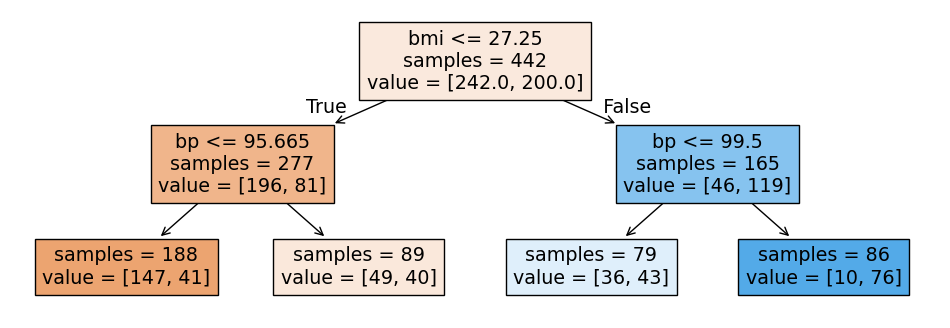

In [23]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# create and fit the model
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(diabetes_X.iloc[:, :4], diabetes_y_risk)

# visualize the model
plot_tree(clf, feature_names=diabetes_X.columns[:4], impurity=False, filled=True)
print("")

### Decision Rules

Let's now define a decision tree a bit more formally.
* A decision rule $r : \mathcal{X} \to \{\text{true}, \text{false}\}$ is a partition of the feature space into two disjoint regions, e.g.:
$$ r(x) = \begin{cases}\text{true} & \text{if } x_\text{bmi} \leq 27.25 \\ \text{false} & \text{if } x_\text{bmi} > 27.25 \end{cases} $$
* Normally, a rule applies to only one feature or attribute $x_j$ of $x$.
* If $x_j$ is continuous, the rule normally separates inputs $x_j$ into disjoint intervals $-\infty, c], (c, \infty)$.

### Decision Trees: Definition

A decision tree is a (usually binary) tree, where:
* Each internal node $n$ corresponds to a rule $r_n$
* The $j$-th edge out of $n$ is associated with a rule value $v_j$, and we follow the $j$-th edge if $r_n(x)=v_j$
* Each leaf node $l$ contains a prediction $f(x)$
* Given input $x$, we start at the root, apply its rule, follow the edge that corresponds to the outcome, and repeat recursively.

## Exercise 2: Implement a Decision Tree classifier

Now, let's train a Decision Tree on the Iris flowers dataset!
**IMPORTANT**: use only the first two features: sepal length and sepal width.

But first, let's visualize our data:

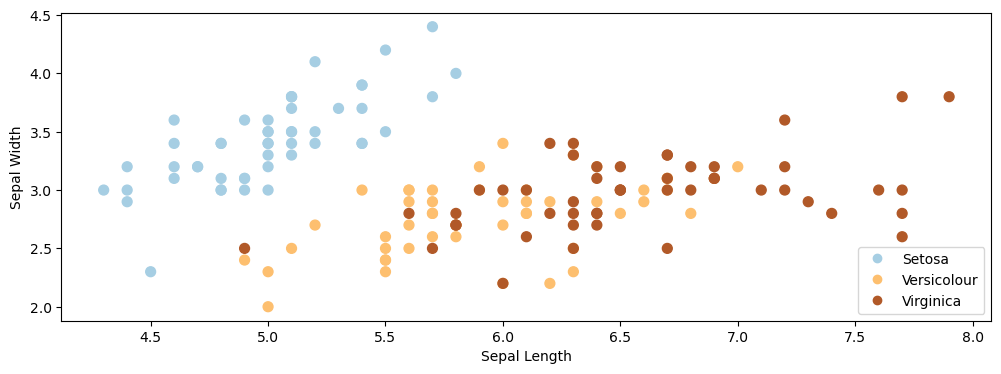

In [26]:
# Plot also the training points
p1 = plt.scatter(
    iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y, s=50, cmap=plt.cm.Paired
)
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend(
    handles=p1.legend_elements()[0],
    labels=["Setosa", "Versicolour", "Virginica"],
    loc="lower right",
)

Ok. Now, let's implement and train our Decision Tree classifier using the Iris flowers dataset.
Remember to check the documentation of the [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).


0.7763909774436091
0.7733333333333334


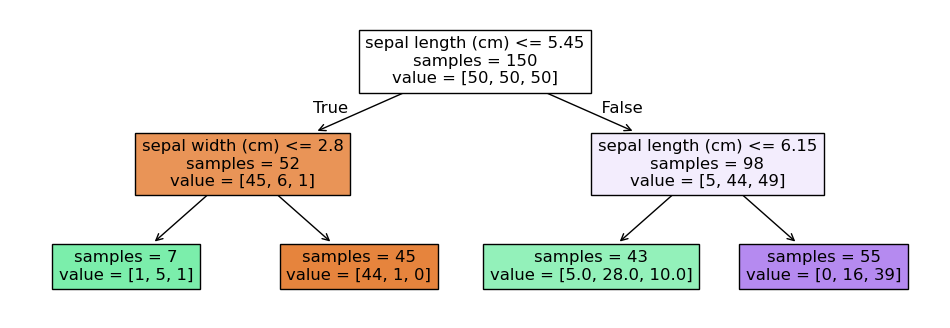

In [35]:
# sepal length and sepal width only
iris_X_small = iris_X.iloc[:, 0:2]
iris_X_small.head()

# create and fit the model
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(iris_X_small, iris_y)

# visualize the model
plot_tree(clf, feature_names=iris_X_small.columns[:2], impurity=False, filled=True)
print("")

# how is the model performing? 
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

y_pred = clf.predict(iris_X_small)
bal = balanced_accuracy_score(iris_y, y_pred)
f1 = f1_score(iris_y, y_pred, average='weighted')
print(f1)
print(bal)

**Question:** Use your trained model to predict the same data used for training. How is it performing?

*Tip:* You can compare the model prediction with the true labels using the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score), although [there are many metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

Balanced accuracy of 0.773 and a F1 score of 0.776. I guess that's fairly good? My ML algorithm was getting balanced accuracies of >0.85. 

## Exercise 3: Understand decision boundaries

Use the [`DecisionBoundaryDisplay`](https://scikit-learn.org/dev/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html) class from scikit-learn to analyze how the classifier you built performed.

In [ ]:
# import library
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay


InvalidIndexError: (slice(None, None, None), 0)

**Question:** do you see a problem with the decision boundaries above? Avoid searching in the Internet and instead explain it with your own words.

_Answer_: add answer

## Exercise 4: Understand decision rules

Use the [`plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) function to visualize the tree of your classifier.

In [ ]:
# add code

**Question:** Can you match points from the decision boundary above to the tree visualized here? Mention an example.

_Answer_: add answer

## Exercise 5: Analyze the learning algorithm

Based on your code in Exercise 2, and using your own words, answer the following questions:
* What's the type of the ML approach?
* What's the model class?
* What's the objective function? Can we change the objective function for this model class?
* What's the optimizer?

_Answer_: add answer